In [14]:
#!/usr/bin/env python

import sys
sys.path.insert(0,'/Users/cmdb/projects/ConfocalAnalysis')
sys.path.insert(0,'/Users/babygirljohnston/Documents/ConfocalAnalysis/ConfocalAnalysis')
sys.path.insert(0,'/Users/babygirljohnston/Documents/Confocal_Xiuqi/scikit-image')

from czifile import CziFile
import numpy as np
from math import sqrt
from skimage.feature import blob_log
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.cluster import DBSCAN
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
import operator
#import matplotlib.cm as cm

#%matplotlib qt 
    #interactive mode of plt

#%matplotlib inline 
    # plt in line with notebook
'''Global variables'''
colomap=["Blues_r","gray","Greens_r","Reds_r"] # colormap for channels
labell=['yellow','yellow','yellow','yellow'] # label color for blobs

'''Setup tips'''
# pip install scikit-image # if not working, compile from source
# pip install -U scikit-learn
# If weird errors happen, try update the packages except 'pip install setuptools==33.1.1'
# different mpl might have version clahes, remember to clean the older version.
# I manually replace the /System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/mpl_toolkits
# with the newer version from /Library/Python/2.7/site-packages/mpl_toolkits

"""Useful Functions"""

def GetOneChannel( czi_file, channel ):
# this function takes the whole .czi file and return a single channel .czi
    stacknumber=czi_file.shape[3]
    OneChannel=[czi_file[0,channel,0,index].T[0].T for index in range(stacknumber)]
    return OneChannel

def FindBlobs( OneChannel,thresh=0.2 ):
# this function takes output from GetOneChannel (a single channel .czi file input)
# return all the blobs in a dict & a structured list & a flattened list
# Dict    # "Y,X,Z"->[radius, intensity]
# struct. List    # [[[Y,X,Z1,radius,intensity],[Y,X,Z1,...]...],...,[[Y,X,Zn,...],...]],np.array
# flat. List    # [[Y1,X1,Z1],[Y2,X2,Z2],[Y3,X3,Z3],...,[Yn,X3,Z3]]
  
    blobs_dict={}
    blobsAll=[]
    blobsList=[]
    stacknumber=len(OneChannel)
    
    for z in range(stacknumber):
        planeblobs=[]
        """Blob Recognition Parameters here"""
        log = blob_log(OneChannel[z], max_sigma=30, num_sigma=10,min_sigma =3, threshold=thresh)
        # Radius of the blob
        log[:, 2] = log[:, 2] * sqrt(2)
        # intensity
        blob_intensity=np.zeros(len(log[:,0]))
        
        for i in range(len(log[:,0])):
            blob_intensity[i]=OneChannel[z][int(log[i,0]),int(log[i,1])]
        
        for i in range(len(log[:,2])):
            position=np.append(log[i,0:2],z)
            position=map(int,position)
            blobs_dict["{},{},{}".format(position[0],position[1],position[2])]=[log[i,2],blob_intensity[i]]
            blobsfeature=[log[i,0],log[i,1],z,log[i,2],blob_intensity[i]]
            print blobsfeature
            planeblobs.append(blobsfeature)
            blobsList.append(position)
        
        blobsAll.append(planeblobs)
    
    blobsAll=np.array(blobsAll)
    blobsList=np.array(blobsList)
    
    return blobs_dict,blobsAll,blobsList



def GetClustersOneChannel( blobsList ):
# this function takes the dict and flattened list from FindBlobs
# return the clusters
###  [[[cluster1_dot1],[cluster1_dot2],...],
#     [[cluster2_dot1],[cluster2_dot2]...],
#     [...],...,
#     [[clusterN_dot1],[clusterN_dot2]] ]

    """3D clustering of Blobs"""
    db = DBSCAN(eps=2, min_samples=2).fit(blobsList)  # eps is the max distance between 2 dots in one cluster
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    print('Estimated number of clusters: %d' % n_clusters_)
#     print("Silhouette Coefficient: %0.3f"
#           % metrics.silhouette_score(blobsList, labels))
    
    """Group up the dots within a cluster"""
    clusters=[]
    for i in range(n_clusters_):
        cluster=[]
        ## Extract X,Y,Z location of the points based on clusters
        positions=np.argwhere(labels==i)
        for j in range(len(positions)):
            cluster.append(blobsList[positions[j]])
        #print cluster
        clusters.append(cluster)
    
    return clusters

def SignalPositionsOneChannel( clusters,blobs_dict ):
# This function takes the clusters List from GetClustersOneChannel
# return the calculated signal position in this one channel all stacks
# [[Y,X,Z,avgIntensity],[Y,X,Z,avgIntensity],...,[Y,X,Z,avgIntensity]]
    """Find the actual signal location"""
    signals=[]
    for i in range(len(clusters)):
        signal=[]
        dots=[]
        ## extract the intensity of the dot in the cluster (from the dictionary)
        for j in range(len(clusters[i])):
            #print clusters[i][j][0]
            dot=clusters[i][j][0]
            intensity=blobs_dict["{},{},{}".format(clusters[i][j][0][0],clusters[i][j][0][1],clusters[i][j][0][2])][1]
            dot=np.append(dot,intensity)
            dots.append(dot)
        # Calculating the actual dot location
        intensity_sum=sum(dots[index][3] for index in range(len(dots)))
        avgIntensity=intensity_sum/len(dots)
        y=sum(dots[index][0]*dots[index][3]/intensity_sum for index in range(len(dots)))
        x=sum(dots[index][1]*dots[index][3]/intensity_sum for index in range(len(dots)))
        z=sum(dots[index][2]*dots[index][3]/intensity_sum for index in range(len(dots)))
        signal=[y,x,z,avgIntensity]
        signals.append(signal)
    signals=np.array(signals)
    return signals

def ToActualScale(list):
# This function takes a [n_sample,[Y,X,Z,Intensity]] LIST
# convert to the actual scale of the coordinates
    """Adjust Parameters"""
    # 63X objective, unit: um
    x_scale=0.099
    y_scale=0.099
    z_scale=0.2
    actual=np.zeros((len(list),len(list[0])))
    for i in range(len(list)):
        actual[i][0]=list[i][0]*y_scale
        actual[i][1]=list[i][1]*x_scale
        actual[i][2]=list[i][2]*z_scale
        if len(list[0])==4:
            actual[i][3]=list[i][3]
    return actual

def GetDistance(element1,element2):
# This function takes two [Y,X,Z]
# return euclidean distance
    distance=sqrt((element1[0]-element2[0])**2+(element1[1]-element2[1])**2+(element1[2]-element2[2])**2)
    return distance

def FindPairs( signals1,signals2,limit=1.2 ):
# This function takes 2 signals-Lists generated in SignalPositionsOneChannel
# return pairs  (LIST)
# [[sig1_idx1,sig2_idx1,dist],[sig1_idx2,sig2_idx2,dist],...,[sig1_idxN,sig2_idxN,dist]]
    pairs=[]
    signals1=ToActualScale(signals1)
    signals2=ToActualScale(signals2)
    #print signals1
    #print signals2
    
    # Brute-Force calculate the distance matrix between the two signal groups
    # 
    row_num= len(signals1)
    col_num= len(signals2)
    matrix=np.zeros((row_num,col_num))
    for i in range(row_num):
        for j in range(col_num):
            matrix[i][j]=GetDistance(signals1[i],signals2[j])
    while 1:
        min_idx=matrix.argmin()
        row=min_idx/col_num
        col=min_idx%col_num
        distance=matrix[row][col]
        if distance > limit:
            break
        pairs.append([row,col,distance])
        matrix[row,:]=100
        matrix[:,col]=100
    return pairs


def PlotOriginal(image_arrays,channel,stack):
    # This function takes the czifile from the reader line, specific channel, stack and colormap
    # plot the image
    images=GetOneChannel(image_arrays,channel)
    fig=plt.figure(figsize=(20,20))
    mapp=plt.imshow(images[stack],cmap=colomap[channel])
    cbar = fig.colorbar(mapp, ticks=[0, 65535])
    cbar.ax.set_yticklabels(['0', '65535'])
    plt.title("Channel {}, Stack {}".format(channel,stack),fontsize=20)
    return mapp

def PlotCheckBlobs(OneChannel, blobsAll, channel, stack):
    # Take Single channel all stack, blobsAll from FindBlobs, stack,label
    # Plot the specific image on that stack, together with the blobs.
    fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(20,20))
    mapp=plt.imshow(OneChannel[stack],cmap=colomap[channel])

    cbar = fig.colorbar(mapp, ticks=[0, 65535])
    cbar.ax.set_yticklabels(['0', '65535'])

    log = blobsAll[stack]
    #print log
    for blob in log:
        #print blob
        y, x, z,radius,intensity = blob
        c = plt.Circle((x, y), radius, color=labell[channel], linewidth=2, fill=False)   
        axes.add_patch(c)
    
    plt.title("Channel {}, Stack {}".format(channel,stack),fontsize=20)
    
    return mapp

def PlotCheckClusters(clusters):
    # This function takes the clusters & plot each cluster in a different color to inspect
    colors = cm.rainbow(np.linspace(0, 1, len(clusters_ss)))
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    for cluster, c in zip(clusters_ss, colors):
        #print cluster
        y,x,z=np.array([cluster[index] for index in range(len(cluster))]).T
        ax.scatter(x, y, z,color=c)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    return 0

def PlotPairs3D(pairs_coords, threshold=0):
    # This function takes the actual pair_coord, 
    #[[[y1,x1,z1],[y1_,x1_,z1_]],
    # [[y2,x2,z2],[y2_,x2_,z2_]],
    # ...
    #]
    # takes the min threshold and plot the pairs above the threshold in 3D
    
    selected=[]
    for pair in pairs_coords:
        #print pair
        distance=GetDistance(pair[0],pair[1])
        if distance>threshold:
            selected.append(pair)

    y_s,x_s,z_s = np.array([selected[index][0] for index in range(len(selected))]).T
    y_k,x_k,z_k = np.array([selected[index][1] for index in range(len(selected))]).T
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_s, y_s, z_s,color='green')
    ax.scatter(x_k, y_k, z_k,color='red')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_zlim([-1,7])
    plt.title("3D Plot of Signal Pairs with Distance above {} um".format(threshold),fontsize=20)
    return ax

def PlotPairsImage(image_arrays,channel, stack, pair_coord_pic, threshold=0):
    OneChannel_back=GetOneChannel(image_arrays,channel)
    # len(OneChannel_back) # stack number

    # Show the background channel
    fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(20,20))
    mapp=plt.imshow(OneChannel_back[stack],cmap=colomap[channel])

    cbar = fig.colorbar(mapp, ticks=[0, 65535])
    cbar.ax.set_yticklabels(['0', '65535'])

    #print pair_coord_pic

    selected=[]
    for pair in pair_coord_pic:
        #print pair
        distance=GetDistance(pair[0],pair[1])
        if distance<threshold:  # only take the pairs with distance above threshold
            continue
        if pair[0][2]>stack+0.5 or pair[0][2]<stack-0.5: # take the pairs near the stack
            continue

        selected.append(pair)

    #print selected

    y_s,x_s,z_s = np.array([selected[index][0] for index in range(len(selected))]).T
    y_k,x_k,z_k = np.array([selected[index][1] for index in range(len(selected))]).T

    axes.scatter(x_s, y_s,color='green')
    axes.scatter(x_k, y_k,color='red')
    axes.set_xlabel('X Label')
    axes.set_ylabel('Y Label')

    plt.title("Channel {}, Stack {}".format(channel,stack),fontsize=20)
    
    return axes

def PlotPairsProjected(image_arrays,channel,stack,pair_coord_pic,threshold=0):

    OneChannel_back=GetOneChannel(image_arrays,channel)

    # Show background
    fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(20,20))
    mapp=plt.imshow(OneChannel_back[stack],cmap=colomap[channel])

    cbar = fig.colorbar(mapp, ticks=[0, 65535])
    cbar.ax.set_yticklabels(['0', '65535'])

    selected=[]
    for pair in pair_coord_pic:
        #print pair
        distance=GetDistance(pair[0],pair[1])
        if distance>threshold:
            selected.append(pair)

    # plot all the long pairs
    y_s,x_s,z_s = np.array([selected[index][0] for index in range(len(selected))]).T
    y_k,x_k,z_k = np.array([selected[index][1] for index in range(len(selected))]).T

    axes.scatter(x_s, y_s,color='green')
    axes.scatter(x_k, y_k,color='red')

    plt.title("Channel {}, Stack {}".format(channel,stack),fontsize=20)

    
    return 

In [6]:
""" Image Input """
#with CziFile('/Users/babygirljohnston/Documents/Confocal_Xiuqi/Image_1.czi') as czi:
with CziFile('/Users/cmdb/data/Image_1.czi') as czi:
    image_arrays=czi.asarray()
# 63X objective, unit: um

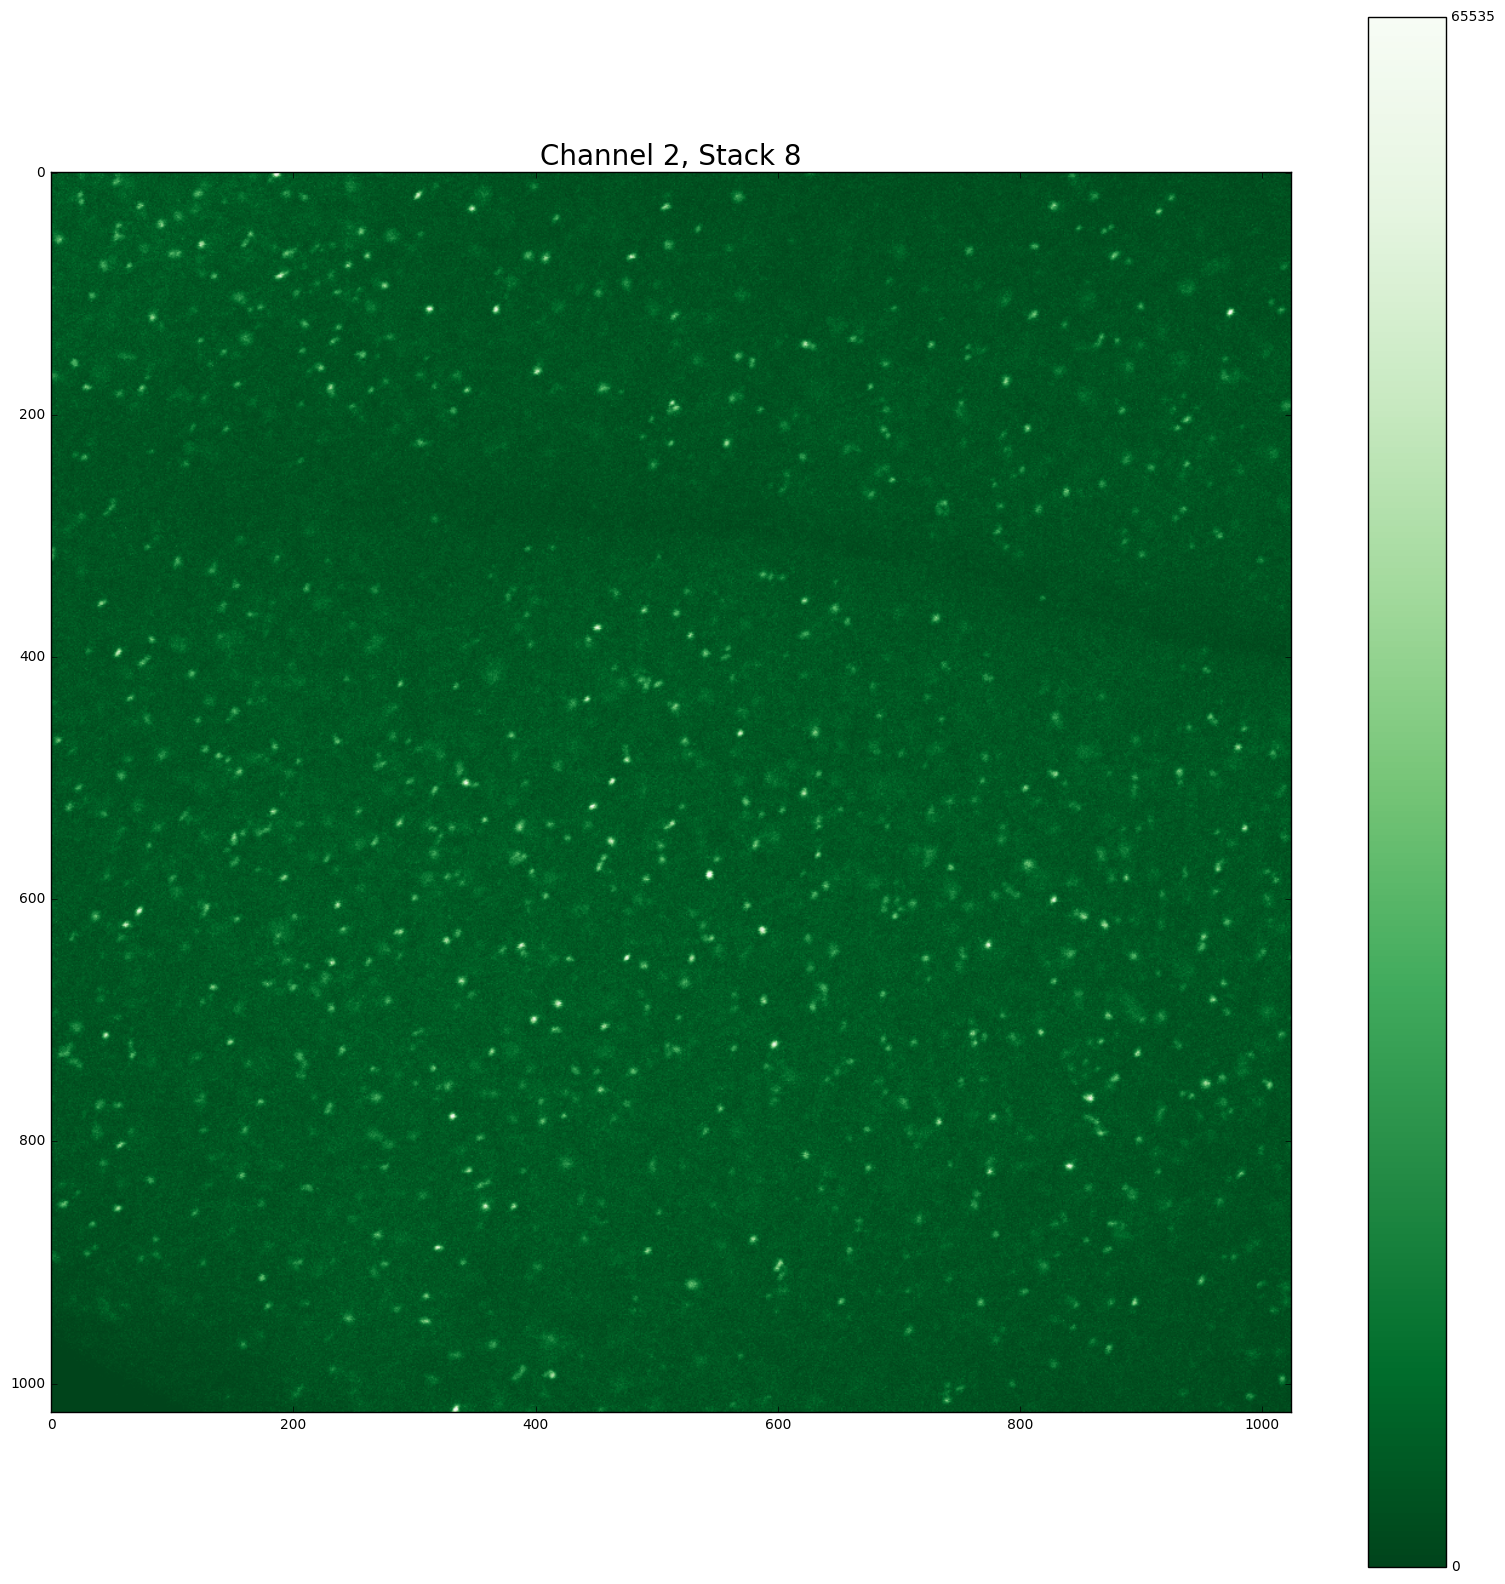

In [21]:
## Plot the original image of any channel, any stack

channel=2
stack=8

PlotOriginal(image_arrays,channel,stack)
plt.savefig("Image1_original_Ch{}_stack{}".format(channel,stack))
# plt.plot((x1, x2), (y1, y2), 'k-') #to draw a line from the point (x1, y1) to the point (x2, y2)

In [22]:
"""Image Processing -- (time consuming: several minutes)""" 
# Find blobs in one channel image image for ss
OneChannel_ss=GetOneChannel(image_arrays,2)
blobs_dict_ss,blobsAll_ss,blobsList_ss=FindBlobs(OneChannel_ss,0.1)

# Find blobs in one channel image stack for klu
#OneChannel_klu=GetOneChannel(image_arrays,3)
#blobs_dict_klu,blobsAll_klu,blobsList_klu=FindBlobs(OneChannel_klu,0.1)

[0.0, 221.0, 0, 8.4852813742385713, 23733.0]
[0.0, 456.0, 0, 4.2426406871192857, 26251.0]
[0.0, 555.0, 0, 8.4852813742385713, 9801.0]
[8.0, 929.0, 0, 4.2426406871192857, 38249.0]
[10.0, 168.0, 0, 4.2426406871192857, 27156.0]
[11.0, 293.0, 0, 4.2426406871192857, 42660.0]
[13.0, 780.0, 0, 4.2426406871192857, 46778.0]
[14.0, 590.0, 0, 4.2426406871192857, 37262.0]
[22.0, 610.0, 0, 4.2426406871192857, 38003.0]
[24.0, 414.0, 0, 4.2426406871192857, 26895.0]
[26.0, 1020.0, 0, 4.2426406871192857, 65535.0]
[28.0, 473.0, 0, 4.2426406871192857, 47842.0]
[31.0, 981.0, 0, 4.2426406871192857, 33063.0]
[32.0, 782.0, 0, 4.2426406871192857, 42631.0]
[34.0, 177.0, 0, 4.2426406871192857, 21887.0]
[36.0, 5.0, 0, 4.2426406871192857, 19949.0]
[40.0, 265.0, 0, 4.2426406871192857, 24274.0]
[42.0, 529.0, 0, 4.2426406871192857, 29697.0]
[43.0, 113.0, 0, 4.2426406871192857, 42958.0]
[44.0, 312.0, 0, 4.2426406871192857, 33501.0]
[44.0, 349.0, 0, 4.2426406871192857, 42866.0]
[52.0, 736.0, 0, 4.2426406871192857, 272

[0.0, 221.0, 1, 8.4852813742385713, 18279.0]
[0.0, 341.0, 1, 4.2426406871192857, 15539.0]
[0.0, 456.0, 1, 4.2426406871192857, 31151.0]
[0.0, 555.0, 1, 8.4852813742385713, 7753.0]
[8.0, 929.0, 1, 4.2426406871192857, 36703.0]
[10.0, 168.0, 1, 4.2426406871192857, 21686.0]
[11.0, 293.0, 1, 4.2426406871192857, 34417.0]
[13.0, 780.0, 1, 4.2426406871192857, 41407.0]
[14.0, 590.0, 1, 4.2426406871192857, 17526.0]
[22.0, 610.0, 1, 4.2426406871192857, 65535.0]
[24.0, 414.0, 1, 4.2426406871192857, 31553.0]
[26.0, 1020.0, 1, 4.2426406871192857, 65535.0]
[27.0, 909.0, 1, 4.2426406871192857, 18109.0]
[28.0, 473.0, 1, 4.2426406871192857, 34461.0]
[32.0, 782.0, 1, 4.2426406871192857, 65535.0]
[32.0, 981.0, 1, 4.2426406871192857, 34697.0]
[34.0, 177.0, 1, 4.2426406871192857, 26818.0]
[40.0, 265.0, 1, 4.2426406871192857, 32919.0]
[40.0, 373.0, 1, 4.2426406871192857, 24967.0]
[42.0, 114.0, 1, 4.2426406871192857, 47548.0]
[44.0, 312.0, 1, 4.2426406871192857, 33065.0]
[44.0, 349.0, 1, 4.2426406871192857, 38

[0.0, 221.0, 2, 8.4852813742385713, 19541.0]
[0.0, 457.0, 2, 4.2426406871192857, 33468.0]
[4.0, 555.0, 2, 4.2426406871192857, 21729.0]
[8.0, 849.0, 2, 4.2426406871192857, 28406.0]
[11.0, 293.0, 2, 4.2426406871192857, 30348.0]
[13.0, 781.0, 2, 4.2426406871192857, 28525.0]
[17.0, 252.0, 2, 4.2426406871192857, 32841.0]
[22.0, 610.0, 2, 4.2426406871192857, 64513.0]
[23.0, 121.0, 2, 4.2426406871192857, 19365.0]
[25.0, 353.0, 2, 4.2426406871192857, 29555.0]
[26.0, 909.0, 2, 4.2426406871192857, 42966.0]
[26.0, 1021.0, 2, 4.2426406871192857, 40535.0]
[31.0, 782.0, 2, 4.2426406871192857, 65535.0]
[31.0, 981.0, 2, 4.2426406871192857, 31865.0]
[34.0, 177.0, 2, 4.2426406871192857, 27934.0]
[36.0, 899.0, 2, 4.2426406871192857, 31005.0]
[40.0, 266.0, 2, 4.2426406871192857, 32205.0]
[40.0, 374.0, 2, 4.2426406871192857, 35887.0]
[42.0, 114.0, 2, 4.2426406871192857, 65535.0]
[44.0, 350.0, 2, 4.2426406871192857, 37573.0]
[48.0, 462.0, 2, 4.2426406871192857, 35603.0]
[52.0, 737.0, 2, 4.2426406871192857, 

[0.0, 458.0, 3, 4.2426406871192857, 14953.0]
[8.0, 849.0, 3, 4.2426406871192857, 28404.0]
[13.0, 59.0, 3, 4.2426406871192857, 29828.0]
[17.0, 252.0, 3, 4.2426406871192857, 54224.0]
[18.0, 356.0, 3, 4.2426406871192857, 33054.0]
[23.0, 610.0, 3, 4.2426406871192857, 23908.0]
[24.0, 121.0, 3, 4.2426406871192857, 38477.0]
[27.0, 909.0, 3, 4.2426406871192857, 44623.0]
[32.0, 782.0, 3, 4.2426406871192857, 57185.0]
[36.0, 899.0, 3, 4.2426406871192857, 32641.0]
[40.0, 374.0, 3, 4.2426406871192857, 50493.0]
[43.0, 114.0, 3, 4.2426406871192857, 48769.0]
[45.0, 350.0, 3, 4.2426406871192857, 20203.0]
[48.0, 462.0, 3, 4.2426406871192857, 63528.0]
[53.0, 279.0, 3, 4.2426406871192857, 28225.0]
[54.0, 658.0, 3, 4.2426406871192857, 60466.0]
[55.0, 249.0, 3, 4.2426406871192857, 39687.0]
[58.0, 588.0, 3, 4.2426406871192857, 17578.0]
[60.0, 94.0, 3, 4.2426406871192857, 36252.0]
[62.0, 421.0, 3, 4.2426406871192857, 54509.0]
[64.0, 84.0, 3, 4.2426406871192857, 31871.0]
[66.0, 698.0, 3, 4.2426406871192857, 17

[0.0, 625.0, 4, 4.2426406871192857, 31955.0]
[8.0, 849.0, 4, 4.2426406871192857, 37396.0]
[11.0, 246.0, 4, 4.2426406871192857, 26651.0]
[13.0, 59.0, 4, 4.2426406871192857, 26510.0]
[17.0, 252.0, 4, 4.2426406871192857, 58139.0]
[18.0, 356.0, 4, 4.2426406871192857, 54568.0]
[20.0, 859.0, 4, 4.2426406871192857, 16782.0]
[21.0, 566.0, 4, 4.2426406871192857, 24879.0]
[24.0, 121.0, 4, 4.2426406871192857, 51508.0]
[27.0, 910.0, 4, 4.2426406871192857, 26312.0]
[28.0, 827.0, 4, 4.2426406871192857, 14721.0]
[32.0, 782.0, 4, 4.2426406871192857, 27429.0]
[37.0, 104.0, 4, 4.2426406871192857, 35610.0]
[40.0, 374.0, 4, 4.2426406871192857, 58584.0]
[49.0, 462.0, 4, 4.2426406871192857, 52558.0]
[53.0, 280.0, 4, 4.2426406871192857, 53473.0]
[54.0, 659.0, 4, 4.2426406871192857, 17593.0]
[55.0, 250.0, 4, 4.2426406871192857, 39327.0]
[57.0, 131.0, 4, 4.2426406871192857, 36300.0]
[60.0, 94.0, 4, 4.2426406871192857, 33287.0]
[61.0, 509.0, 4, 4.2426406871192857, 33020.0]
[62.0, 421.0, 4, 4.2426406871192857, 2

[0.0, 167.0, 5, 4.2426406871192857, 29857.0]
[0.0, 625.0, 5, 4.2426406871192857, 46167.0]
[8.0, 849.0, 5, 4.2426406871192857, 21343.0]
[9.0, 63.0, 5, 4.2426406871192857, 41460.0]
[11.0, 247.0, 5, 4.2426406871192857, 25701.0]
[17.0, 252.0, 5, 4.2426406871192857, 41185.0]
[17.0, 357.0, 5, 4.2426406871192857, 65161.0]
[20.0, 859.0, 5, 4.2426406871192857, 44304.0]
[21.0, 566.0, 5, 4.2426406871192857, 43959.0]
[23.0, 121.0, 5, 4.2426406871192857, 49198.0]
[29.0, 827.0, 5, 4.2426406871192857, 29897.0]
[37.0, 104.0, 5, 4.2426406871192857, 43280.0]
[40.0, 374.0, 5, 4.2426406871192857, 35114.0]
[48.0, 463.0, 5, 4.2426406871192857, 34278.0]
[50.0, 947.0, 5, 4.2426406871192857, 18966.0]
[53.0, 280.0, 5, 4.2426406871192857, 65535.0]
[55.0, 250.0, 5, 4.2426406871192857, 35989.0]
[56.0, 6.0, 5, 4.2426406871192857, 29188.0]
[57.0, 131.0, 5, 4.2426406871192857, 39421.0]
[61.0, 509.0, 5, 4.2426406871192857, 60260.0]
[65.0, 349.0, 5, 4.2426406871192857, 31841.0]
[65.0, 757.0, 5, 4.2426406871192857, 2765

[0.0, 38.0, 6, 4.2426406871192857, 24625.0]
[0.0, 166.0, 6, 4.2426406871192857, 25561.0]
[0.0, 186.0, 6, 4.2426406871192857, 19477.0]
[0.0, 625.0, 6, 4.2426406871192857, 50721.0]
[9.0, 53.0, 6, 4.2426406871192857, 42604.0]
[9.0, 64.0, 6, 4.2426406871192857, 40438.0]
[12.0, 247.0, 6, 4.2426406871192857, 45014.0]
[17.0, 357.0, 6, 4.2426406871192857, 54774.0]
[19.0, 121.0, 6, 4.2426406871192857, 34729.0]
[19.0, 193.0, 6, 4.2426406871192857, 24560.0]
[20.0, 302.0, 6, 4.2426406871192857, 24607.0]
[20.0, 859.0, 6, 4.2426406871192857, 58203.0]
[21.0, 566.0, 6, 4.2426406871192857, 57594.0]
[29.0, 827.0, 6, 4.2426406871192857, 54125.0]
[37.0, 104.0, 6, 4.2426406871192857, 50743.0]
[53.0, 280.0, 6, 4.2426406871192857, 65535.0]
[56.0, 6.0, 6, 4.2426406871192857, 42130.0]
[57.0, 131.0, 6, 4.2426406871192857, 31008.0]
[61.0, 509.0, 6, 4.2426406871192857, 62509.0]
[65.0, 349.0, 6, 4.2426406871192857, 26735.0]
[66.0, 698.0, 6, 4.2426406871192857, 23245.0]
[66.0, 757.0, 6, 4.2426406871192857, 43130.0]

[0.0, 626.0, 7, 4.2426406871192857, 33775.0]
[1.0, 185.0, 7, 4.2426406871192857, 33434.0]
[9.0, 53.0, 7, 4.2426406871192857, 43296.0]
[12.0, 247.0, 7, 4.2426406871192857, 31827.0]
[18.0, 121.0, 7, 4.2426406871192857, 45298.0]
[18.0, 193.0, 7, 4.2426406871192857, 33537.0]
[18.0, 357.0, 7, 4.2426406871192857, 25049.0]
[20.0, 302.0, 7, 4.2426406871192857, 44669.0]
[20.0, 859.0, 7, 4.2426406871192857, 46980.0]
[21.0, 566.0, 7, 4.2426406871192857, 52964.0]
[29.0, 507.0, 7, 4.2426406871192857, 36583.0]
[29.0, 827.0, 7, 4.2426406871192857, 42452.0]
[31.0, 347.0, 7, 4.2426406871192857, 28721.0]
[33.0, 914.0, 7, 4.2426406871192857, 22810.0]
[37.0, 104.0, 7, 4.2426406871192857, 38699.0]
[53.0, 280.0, 7, 4.2426406871192857, 37199.0]
[54.0, 54.0, 7, 4.2426406871192857, 23171.0]
[56.0, 6.0, 7, 4.2426406871192857, 47533.0]
[61.0, 509.0, 7, 4.2426406871192857, 38843.0]
[62.0, 811.0, 7, 4.2426406871192857, 18977.0]
[65.0, 699.0, 7, 4.2426406871192857, 16170.0]
[66.0, 757.0, 7, 4.2426406871192857, 4083

[0.0, 186.0, 8, 4.2426406871192857, 39600.0]
[0.0, 626.0, 8, 4.2426406871192857, 16167.0]
[8.0, 54.0, 8, 4.2426406871192857, 22641.0]
[18.0, 121.0, 8, 4.2426406871192857, 27969.0]
[18.0, 194.0, 8, 4.2426406871192857, 18727.0]
[20.0, 302.0, 8, 4.2426406871192857, 51525.0]
[20.0, 861.0, 8, 4.2426406871192857, 16452.0]
[21.0, 208.0, 8, 4.2426406871192857, 15451.0]
[21.0, 567.0, 8, 4.2426406871192857, 19004.0]
[21.0, 924.0, 8, 4.2426406871192857, 20796.0]
[24.0, 24.0, 8, 4.2426406871192857, 18567.0]
[28.0, 73.0, 8, 4.2426406871192857, 27502.0]
[28.0, 827.0, 8, 4.2426406871192857, 39918.0]
[29.0, 507.0, 8, 4.2426406871192857, 39214.0]
[30.0, 347.0, 8, 4.2426406871192857, 56692.0]
[33.0, 914.0, 8, 4.2426406871192857, 36594.0]
[38.0, 416.0, 8, 4.2426406871192857, 19319.0]
[43.0, 90.0, 8, 4.2426406871192857, 28664.0]
[47.0, 534.0, 8, 4.2426406871192857, 20931.0]
[49.0, 256.0, 8, 4.2426406871192857, 29487.0]
[52.0, 164.0, 8, 4.2426406871192857, 30001.0]
[53.0, 54.0, 8, 4.2426406871192857, 29026

[0.0, 186.0, 9, 4.2426406871192857, 49731.0]
[0.0, 271.0, 9, 4.2426406871192857, 29299.0]
[12.0, 398.0, 9, 4.2426406871192857, 22413.0]
[19.0, 303.0, 9, 4.2426406871192857, 44838.0]
[21.0, 208.0, 9, 4.2426406871192857, 25907.0]
[21.0, 924.0, 9, 4.2426406871192857, 23220.0]
[28.0, 73.0, 9, 4.2426406871192857, 46225.0]
[29.0, 507.0, 9, 4.2426406871192857, 30957.0]
[31.0, 347.0, 9, 4.2426406871192857, 65535.0]
[32.0, 118.0, 9, 4.2426406871192857, 22459.0]
[33.0, 914.0, 9, 4.2426406871192857, 25472.0]
[38.0, 416.0, 9, 4.2426406871192857, 49745.0]
[43.0, 91.0, 9, 4.2426406871192857, 55984.0]
[46.0, 848.0, 9, 4.2426406871192857, 21422.0]
[47.0, 533.0, 9, 4.2426406871192857, 18881.0]
[49.0, 256.0, 9, 4.2426406871192857, 51921.0]
[52.0, 164.0, 9, 4.2426406871192857, 27099.0]
[54.0, 54.0, 9, 4.2426406871192857, 26441.0]
[59.0, 160.0, 9, 4.2426406871192857, 27485.0]
[60.0, 124.0, 9, 4.2426406871192857, 65535.0]
[63.0, 76.0, 9, 4.2426406871192857, 19310.0]
[67.0, 195.0, 9, 4.2426406871192857, 178

[0.0, 186.0, 10, 4.2426406871192857, 41610.0]
[0.0, 272.0, 10, 4.2426406871192857, 44833.0]
[11.0, 127.0, 10, 4.2426406871192857, 41554.0]
[11.0, 318.0, 10, 4.2426406871192857, 23897.0]
[12.0, 398.0, 10, 4.2426406871192857, 39466.0]
[19.0, 303.0, 10, 4.2426406871192857, 20824.0]
[20.0, 157.0, 10, 4.2426406871192857, 31848.0]
[21.0, 209.0, 10, 4.2426406871192857, 27910.0]
[21.0, 924.0, 10, 4.2426406871192857, 29220.0]
[28.0, 74.0, 10, 4.2426406871192857, 34908.0]
[29.0, 508.0, 10, 4.2426406871192857, 17710.0]
[30.0, 348.0, 10, 4.2426406871192857, 48694.0]
[32.0, 118.0, 10, 4.2426406871192857, 35708.0]
[38.0, 417.0, 10, 4.2426406871192857, 28670.0]
[43.0, 91.0, 10, 4.2426406871192857, 54444.0]
[45.0, 245.0, 10, 4.2426406871192857, 35225.0]
[49.0, 256.0, 10, 4.2426406871192857, 57256.0]
[60.0, 124.0, 10, 4.2426406871192857, 65535.0]
[61.0, 245.0, 10, 4.2426406871192857, 19021.0]
[63.0, 77.0, 10, 4.2426406871192857, 36832.0]
[63.0, 299.0, 10, 4.2426406871192857, 33572.0]
[70.0, 479.0, 10, 

[0.0, 186.0, 11, 8.4852813742385713, 14298.0]
[0.0, 272.0, 11, 4.2426406871192857, 51769.0]
[11.0, 127.0, 11, 4.2426406871192857, 52868.0]
[11.0, 149.0, 11, 4.2426406871192857, 31615.0]
[12.0, 398.0, 11, 4.2426406871192857, 42126.0]
[21.0, 157.0, 11, 4.2426406871192857, 27402.0]
[29.0, 73.0, 11, 4.2426406871192857, 16502.0]
[31.0, 348.0, 11, 4.2426406871192857, 38398.0]
[33.0, 118.0, 11, 4.2426406871192857, 34537.0]
[35.0, 216.0, 11, 4.2426406871192857, 18598.0]
[39.0, 417.0, 11, 4.2426406871192857, 17487.0]
[43.0, 91.0, 11, 4.2426406871192857, 48334.0]
[45.0, 245.0, 11, 4.2426406871192857, 65535.0]
[49.0, 256.0, 11, 4.2426406871192857, 43867.0]
[60.0, 124.0, 11, 4.2426406871192857, 63336.0]
[61.0, 179.0, 11, 4.2426406871192857, 22576.0]
[61.0, 245.0, 11, 4.2426406871192857, 32965.0]
[64.0, 76.0, 11, 4.2426406871192857, 50160.0]
[64.0, 299.0, 11, 4.2426406871192857, 31090.0]
[74.0, 889.0, 11, 4.2426406871192857, 30013.0]
[77.0, 43.0, 11, 4.2426406871192857, 41641.0]
[84.0, 125.0, 11, 4

[0.0, 272.0, 12, 4.2426406871192857, 41399.0]
[5.0, 556.0, 12, 4.2426406871192857, 23718.0]
[11.0, 127.0, 12, 4.2426406871192857, 47624.0]
[11.0, 149.0, 12, 4.2426406871192857, 30597.0]
[13.0, 398.0, 12, 4.2426406871192857, 21972.0]
[21.0, 157.0, 12, 4.2426406871192857, 23627.0]
[33.0, 118.0, 12, 4.2426406871192857, 25586.0]
[36.0, 70.0, 12, 4.2426406871192857, 21457.0]
[36.0, 216.0, 12, 4.2426406871192857, 37257.0]
[45.0, 245.0, 12, 4.2426406871192857, 53454.0]
[49.0, 256.0, 12, 4.2426406871192857, 22020.0]
[61.0, 124.0, 12, 4.2426406871192857, 27554.0]
[61.0, 179.0, 12, 4.2426406871192857, 57682.0]
[62.0, 245.0, 12, 4.2426406871192857, 36899.0]
[64.0, 76.0, 12, 4.2426406871192857, 52129.0]
[64.0, 299.0, 12, 4.2426406871192857, 46638.0]
[78.0, 43.0, 12, 4.2426406871192857, 19426.0]
[78.0, 432.0, 12, 4.2426406871192857, 27848.0]
[85.0, 125.0, 12, 4.2426406871192857, 31791.0]
[87.0, 5.0, 12, 4.2426406871192857, 23475.0]
[91.0, 230.0, 12, 4.2426406871192857, 40636.0]
[93.0, 270.0, 12, 4.

[0.0, 273.0, 13, 4.2426406871192857, 18136.0]
[5.0, 556.0, 13, 4.2426406871192857, 31713.0]
[11.0, 127.0, 13, 4.2426406871192857, 27262.0]
[36.0, 216.0, 13, 4.2426406871192857, 48656.0]
[37.0, 70.0, 13, 4.2426406871192857, 31566.0]
[45.0, 246.0, 13, 4.2426406871192857, 44842.0]
[53.0, 577.0, 13, 4.2426406871192857, 21834.0]
[61.0, 179.0, 13, 4.2426406871192857, 65535.0]
[62.0, 245.0, 13, 4.2426406871192857, 25542.0]
[64.0, 76.0, 13, 4.2426406871192857, 30249.0]
[64.0, 299.0, 13, 4.2426406871192857, 34045.0]
[76.0, 133.0, 13, 4.2426406871192857, 23002.0]
[78.0, 432.0, 13, 4.2426406871192857, 39502.0]
[87.0, 4.0, 13, 4.2426406871192857, 29781.0]
[92.0, 230.0, 13, 4.2426406871192857, 44662.0]
[93.0, 270.0, 13, 4.2426406871192857, 21501.0]
[94.0, 499.0, 13, 4.2426406871192857, 28825.0]
[95.0, 436.0, 13, 4.2426406871192857, 21187.0]
[104.0, 155.0, 13, 4.2426406871192857, 23353.0]
[104.0, 858.0, 13, 4.2426406871192857, 25589.0]
[132.0, 667.0, 13, 4.2426406871192857, 49262.0]
[132.0, 915.0, 1

[2.0, 121.0, 14, 4.2426406871192857, 34177.0]
[5.0, 556.0, 14, 4.2426406871192857, 23524.0]
[35.0, 216.0, 14, 4.2426406871192857, 59163.0]
[36.0, 70.0, 14, 4.2426406871192857, 53814.0]
[52.0, 578.0, 14, 4.2426406871192857, 38067.0]
[61.0, 180.0, 14, 4.2426406871192857, 64678.0]
[64.0, 299.0, 14, 4.2426406871192857, 19199.0]
[75.0, 133.0, 14, 4.2426406871192857, 29054.0]
[78.0, 432.0, 14, 4.2426406871192857, 37095.0]
[91.0, 230.0, 14, 4.2426406871192857, 36047.0]
[132.0, 667.0, 14, 4.2426406871192857, 38793.0]
[134.0, 322.0, 14, 4.2426406871192857, 56549.0]
[141.0, 22.0, 14, 4.2426406871192857, 28080.0]
[144.0, 5.0, 14, 4.2426406871192857, 21760.0]
[145.0, 851.0, 14, 4.2426406871192857, 21269.0]
[149.0, 472.0, 14, 4.2426406871192857, 23333.0]
[156.0, 767.0, 14, 4.2426406871192857, 17195.0]
[161.0, 889.0, 14, 4.2426406871192857, 20393.0]
[162.0, 200.0, 14, 4.2426406871192857, 21626.0]
[167.0, 457.0, 14, 4.2426406871192857, 42130.0]
[168.0, 591.0, 14, 4.2426406871192857, 18055.0]
[178.0, 

[1.0, 122.0, 15, 4.2426406871192857, 28579.0]
[35.0, 217.0, 15, 4.2426406871192857, 31157.0]
[36.0, 70.0, 15, 4.2426406871192857, 26844.0]
[52.0, 578.0, 15, 4.2426406871192857, 34863.0]
[61.0, 180.0, 15, 4.2426406871192857, 42169.0]
[72.0, 101.0, 15, 4.2426406871192857, 20356.0]
[76.0, 133.0, 15, 4.2426406871192857, 35631.0]
[78.0, 432.0, 15, 4.2426406871192857, 25754.0]
[79.0, 371.0, 15, 4.2426406871192857, 26234.0]
[92.0, 110.0, 15, 4.2426406871192857, 19378.0]
[119.0, 122.0, 15, 4.2426406871192857, 29611.0]
[123.0, 91.0, 15, 4.2426406871192857, 20654.0]
[134.0, 323.0, 15, 4.2426406871192857, 36257.0]
[137.0, 655.0, 15, 4.2426406871192857, 23222.0]
[141.0, 22.0, 15, 4.2426406871192857, 37610.0]
[149.0, 472.0, 15, 4.2426406871192857, 41678.0]
[167.0, 457.0, 15, 4.2426406871192857, 48878.0]
[197.0, 235.0, 15, 4.2426406871192857, 15395.0]
[199.0, 1008.0, 15, 4.2426406871192857, 17577.0]
[200.0, 699.0, 15, 4.2426406871192857, 47295.0]
[208.0, 721.0, 15, 4.2426406871192857, 35458.0]
[231.

[9.0, 763.0, 16, 4.2426406871192857, 22252.0]
[12.0, 883.0, 16, 4.2426406871192857, 19971.0]
[16.0, 14.0, 16, 4.2426406871192857, 30695.0]
[52.0, 578.0, 16, 4.2426406871192857, 18951.0]
[61.0, 180.0, 16, 4.2426406871192857, 23580.0]
[72.0, 101.0, 16, 4.2426406871192857, 26567.0]
[76.0, 133.0, 16, 4.2426406871192857, 34697.0]
[79.0, 371.0, 16, 4.2426406871192857, 33926.0]
[92.0, 109.0, 16, 4.2426406871192857, 18308.0]
[111.0, 187.0, 16, 4.2426406871192857, 40984.0]
[118.0, 122.0, 16, 4.2426406871192857, 27918.0]
[124.0, 90.0, 16, 4.2426406871192857, 22373.0]
[134.0, 323.0, 16, 4.2426406871192857, 21065.0]
[137.0, 655.0, 16, 4.2426406871192857, 23521.0]
[141.0, 22.0, 16, 4.2426406871192857, 40517.0]
[150.0, 472.0, 16, 4.2426406871192857, 24176.0]
[167.0, 457.0, 16, 4.2426406871192857, 29093.0]
[182.0, 258.0, 16, 4.2426406871192857, 22871.0]
[197.0, 236.0, 16, 4.2426406871192857, 16138.0]
[200.0, 699.0, 16, 4.2426406871192857, 41651.0]
[208.0, 720.0, 16, 4.2426406871192857, 57074.0]
[216.

[9.0, 763.0, 17, 4.2426406871192857, 30427.0]
[12.0, 883.0, 17, 4.2426406871192857, 41848.0]
[13.0, 33.0, 17, 4.2426406871192857, 17488.0]
[16.0, 13.0, 17, 4.2426406871192857, 16959.0]
[20.0, 651.0, 17, 4.2426406871192857, 23578.0]
[38.0, 1023.0, 17, 4.2426406871192857, 19846.0]
[52.0, 30.0, 17, 4.2426406871192857, 21820.0]
[58.0, 577.0, 17, 4.2426406871192857, 22015.0]
[69.0, 653.0, 17, 4.2426406871192857, 30968.0]
[80.0, 371.0, 17, 4.2426406871192857, 35045.0]
[95.0, 0.0, 17, 4.2426406871192857, 15121.0]
[111.0, 187.0, 17, 4.2426406871192857, 27257.0]
[118.0, 122.0, 17, 4.2426406871192857, 27160.0]
[123.0, 91.0, 17, 4.2426406871192857, 27595.0]
[150.0, 473.0, 17, 4.2426406871192857, 27238.0]
[182.0, 258.0, 17, 4.2426406871192857, 21819.0]
[198.0, 236.0, 17, 4.2426406871192857, 22153.0]
[206.0, 436.0, 17, 4.2426406871192857, 17700.0]
[207.0, 721.0, 17, 4.2426406871192857, 42744.0]
[216.0, 751.0, 17, 4.2426406871192857, 40159.0]
[238.0, 791.0, 17, 4.2426406871192857, 19569.0]
[241.0, 1

[8.0, 764.0, 18, 4.2426406871192857, 23992.0]
[12.0, 883.0, 18, 4.2426406871192857, 50307.0]
[19.0, 651.0, 18, 4.2426406871192857, 43894.0]
[35.0, 729.0, 18, 4.2426406871192857, 21485.0]
[38.0, 1023.0, 18, 4.2426406871192857, 20944.0]
[44.0, 743.0, 18, 4.2426406871192857, 21452.0]
[49.0, 700.0, 18, 4.2426406871192857, 24666.0]
[52.0, 30.0, 18, 4.2426406871192857, 18683.0]
[58.0, 577.0, 18, 4.2426406871192857, 33135.0]
[68.0, 653.0, 18, 4.2426406871192857, 57527.0]
[95.0, 0.0, 18, 4.2426406871192857, 32154.0]
[105.0, 775.0, 18, 4.2426406871192857, 31744.0]
[111.0, 187.0, 18, 4.2426406871192857, 32420.0]
[166.0, 748.0, 18, 4.2426406871192857, 30172.0]
[169.0, 978.0, 18, 4.2426406871192857, 18496.0]
[182.0, 258.0, 18, 4.2426406871192857, 22900.0]
[208.0, 721.0, 18, 4.2426406871192857, 22789.0]
[216.0, 751.0, 18, 4.2426406871192857, 32997.0]
[241.0, 196.0, 18, 4.2426406871192857, 30120.0]
[253.0, 713.0, 18, 4.2426406871192857, 19718.0]
[288.0, 605.0, 18, 4.2426406871192857, 25537.0]
[291.0

[0.0, 95.0, 19, 4.2426406871192857, 15840.0]
[10.0, 793.0, 19, 4.2426406871192857, 16627.0]
[12.0, 883.0, 19, 4.2426406871192857, 43384.0]
[20.0, 651.0, 19, 4.2426406871192857, 31948.0]
[22.0, 818.0, 19, 4.2426406871192857, 13080.0]
[23.0, 675.0, 19, 4.2426406871192857, 16966.0]
[31.0, 934.0, 19, 4.2426406871192857, 31537.0]
[34.0, 365.0, 19, 4.2426406871192857, 23947.0]
[35.0, 729.0, 19, 4.2426406871192857, 27632.0]
[38.0, 1023.0, 19, 4.2426406871192857, 28662.0]
[44.0, 743.0, 19, 4.2426406871192857, 21095.0]
[49.0, 700.0, 19, 4.2426406871192857, 32273.0]
[56.0, 930.0, 19, 4.2426406871192857, 30191.0]
[58.0, 577.0, 19, 4.2426406871192857, 35341.0]
[67.0, 50.0, 19, 4.2426406871192857, 24208.0]
[68.0, 611.0, 19, 4.2426406871192857, 19285.0]
[68.0, 652.0, 19, 4.2426406871192857, 52013.0]
[95.0, 0.0, 19, 4.2426406871192857, 35428.0]
[104.0, 915.0, 19, 4.2426406871192857, 21752.0]
[105.0, 774.0, 19, 4.2426406871192857, 43167.0]
[111.0, 187.0, 19, 4.2426406871192857, 20960.0]
[156.0, 996.0,

[0.0, 95.0, 20, 4.2426406871192857, 37587.0]
[0.0, 989.0, 20, 4.2426406871192857, 15613.0]
[5.0, 595.0, 20, 4.2426406871192857, 26201.0]
[9.0, 954.0, 20, 4.2426406871192857, 26258.0]
[10.0, 793.0, 20, 4.2426406871192857, 24372.0]
[12.0, 883.0, 20, 4.2426406871192857, 28012.0]
[20.0, 55.0, 20, 4.2426406871192857, 23887.0]
[22.0, 818.0, 20, 4.2426406871192857, 14037.0]
[23.0, 675.0, 20, 4.2426406871192857, 54164.0]
[30.0, 934.0, 20, 4.2426406871192857, 35495.0]
[34.0, 365.0, 20, 4.2426406871192857, 31797.0]
[35.0, 729.0, 20, 4.2426406871192857, 31851.0]
[38.0, 1023.0, 20, 4.2426406871192857, 33754.0]
[44.0, 743.0, 20, 4.2426406871192857, 24952.0]
[48.0, 480.0, 20, 4.2426406871192857, 21664.0]
[49.0, 700.0, 20, 4.2426406871192857, 42574.0]
[54.0, 811.0, 20, 4.2426406871192857, 21251.0]
[56.0, 930.0, 20, 4.2426406871192857, 27820.0]
[58.0, 577.0, 20, 4.2426406871192857, 22663.0]
[60.0, 710.0, 20, 4.2426406871192857, 34233.0]
[68.0, 50.0, 20, 4.2426406871192857, 25212.0]
[68.0, 611.0, 20, 4

[0.0, 95.0, 21, 4.2426406871192857, 39587.0]
[0.0, 989.0, 21, 4.2426406871192857, 20006.0]
[5.0, 595.0, 21, 4.2426406871192857, 34758.0]
[9.0, 954.0, 21, 4.2426406871192857, 27827.0]
[20.0, 55.0, 21, 4.2426406871192857, 37341.0]
[21.0, 818.0, 21, 4.2426406871192857, 9423.0]
[23.0, 675.0, 21, 4.2426406871192857, 51291.0]
[31.0, 798.0, 21, 4.2426406871192857, 43490.0]
[31.0, 934.0, 21, 4.2426406871192857, 29560.0]
[34.0, 365.0, 21, 4.2426406871192857, 30713.0]
[35.0, 729.0, 21, 4.2426406871192857, 17412.0]
[38.0, 1023.0, 21, 4.2426406871192857, 23593.0]
[43.0, 980.0, 21, 4.2426406871192857, 24015.0]
[48.0, 480.0, 21, 4.2426406871192857, 37122.0]
[49.0, 700.0, 21, 4.2426406871192857, 35192.0]
[54.0, 811.0, 21, 4.2426406871192857, 34389.0]
[56.0, 930.0, 21, 4.2426406871192857, 22892.0]
[60.0, 710.0, 21, 4.2426406871192857, 42302.0]
[68.0, 611.0, 21, 4.2426406871192857, 42877.0]
[68.0, 652.0, 21, 4.2426406871192857, 32987.0]
[71.0, 75.0, 21, 4.2426406871192857, 16963.0]
[75.0, 933.0, 21, 4.

[0.0, 95.0, 22, 4.2426406871192857, 57047.0]
[0.0, 989.0, 22, 4.2426406871192857, 17707.0]
[5.0, 595.0, 22, 4.2426406871192857, 31166.0]
[9.0, 954.0, 22, 4.2426406871192857, 23054.0]
[20.0, 55.0, 22, 4.2426406871192857, 41351.0]
[23.0, 675.0, 22, 4.2426406871192857, 63026.0]
[30.0, 798.0, 22, 4.2426406871192857, 65535.0]
[34.0, 365.0, 22, 4.2426406871192857, 18619.0]
[44.0, 979.0, 22, 4.2426406871192857, 31512.0]
[48.0, 480.0, 22, 4.2426406871192857, 34066.0]
[49.0, 700.0, 22, 4.2426406871192857, 17110.0]
[53.0, 811.0, 22, 4.2426406871192857, 42342.0]
[59.0, 0.0, 22, 4.2426406871192857, 20690.0]
[60.0, 710.0, 22, 4.2426406871192857, 36843.0]
[68.0, 611.0, 22, 4.2426406871192857, 24306.0]
[69.0, 653.0, 22, 4.2426406871192857, 17282.0]
[71.0, 75.0, 22, 4.2426406871192857, 26326.0]
[72.0, 242.0, 22, 4.2426406871192857, 20536.0]
[75.0, 933.0, 22, 4.2426406871192857, 57125.0]
[85.0, 297.0, 22, 4.2426406871192857, 29003.0]
[88.0, 400.0, 22, 4.2426406871192857, 31107.0]
[89.0, 973.0, 22, 4.24

[0.0, 95.0, 23, 4.2426406871192857, 27387.0]
[0.0, 296.0, 23, 4.2426406871192857, 14913.0]
[19.0, 56.0, 23, 4.2426406871192857, 35259.0]
[22.0, 676.0, 23, 4.2426406871192857, 35035.0]
[30.0, 799.0, 23, 4.2426406871192857, 65535.0]
[35.0, 182.0, 23, 4.2426406871192857, 16801.0]
[43.0, 980.0, 23, 4.2426406871192857, 32802.0]
[48.0, 480.0, 23, 4.2426406871192857, 17069.0]
[53.0, 811.0, 23, 4.2426406871192857, 41532.0]
[58.0, 0.0, 23, 4.2426406871192857, 41456.0]
[71.0, 75.0, 23, 4.2426406871192857, 22763.0]
[72.0, 243.0, 23, 4.2426406871192857, 29256.0]
[75.0, 933.0, 23, 4.2426406871192857, 28404.0]
[84.0, 298.0, 23, 4.2426406871192857, 29519.0]
[89.0, 983.0, 23, 4.2426406871192857, 23571.0]
[93.0, 856.0, 23, 4.2426406871192857, 28274.0]
[94.0, 141.0, 23, 4.2426406871192857, 38326.0]
[98.0, 42.0, 23, 4.2426406871192857, 44642.0]
[99.0, 799.0, 23, 4.2426406871192857, 25761.0]
[108.0, 526.0, 23, 4.2426406871192857, 21756.0]
[121.0, 906.0, 23, 4.2426406871192857, 54413.0]
[128.0, 751.0, 23, 

[30.0, 800.0, 25, 4.2426406871192857, 30986.0]
[99.0, 43.0, 25, 4.2426406871192857, 29885.0]
[305.0, 244.0, 25, 4.2426406871192857, 14735.0]
[339.0, 583.0, 25, 4.2426406871192857, 25947.0]
[347.0, 766.0, 25, 4.2426406871192857, 30820.0]
[432.0, 279.0, 25, 4.2426406871192857, 45030.0]
[465.0, 82.0, 25, 4.2426406871192857, 29403.0]
[466.0, 423.0, 25, 4.2426406871192857, 17334.0]
[475.0, 681.0, 25, 4.2426406871192857, 17595.0]
[513.0, 450.0, 25, 4.2426406871192857, 65535.0]
[534.0, 308.0, 25, 4.2426406871192857, 27721.0]
[569.0, 32.0, 25, 4.2426406871192857, 20186.0]
[625.0, 522.0, 25, 4.2426406871192857, 27414.0]
[662.0, 590.0, 25, 4.2426406871192857, 26343.0]
[739.0, 452.0, 25, 4.2426406871192857, 17631.0]
[778.0, 293.0, 25, 4.2426406871192857, 17559.0]
[800.0, 833.0, 25, 4.2426406871192857, 13748.0]
[861.0, 858.0, 25, 4.2426406871192857, 10940.0]
[881.0, 960.0, 25, 4.2426406871192857, 23488.0]
[888.0, 845.0, 25, 4.2426406871192857, 17258.0]
[1004.0, 713.0, 25, 4.2426406871192857, 20015

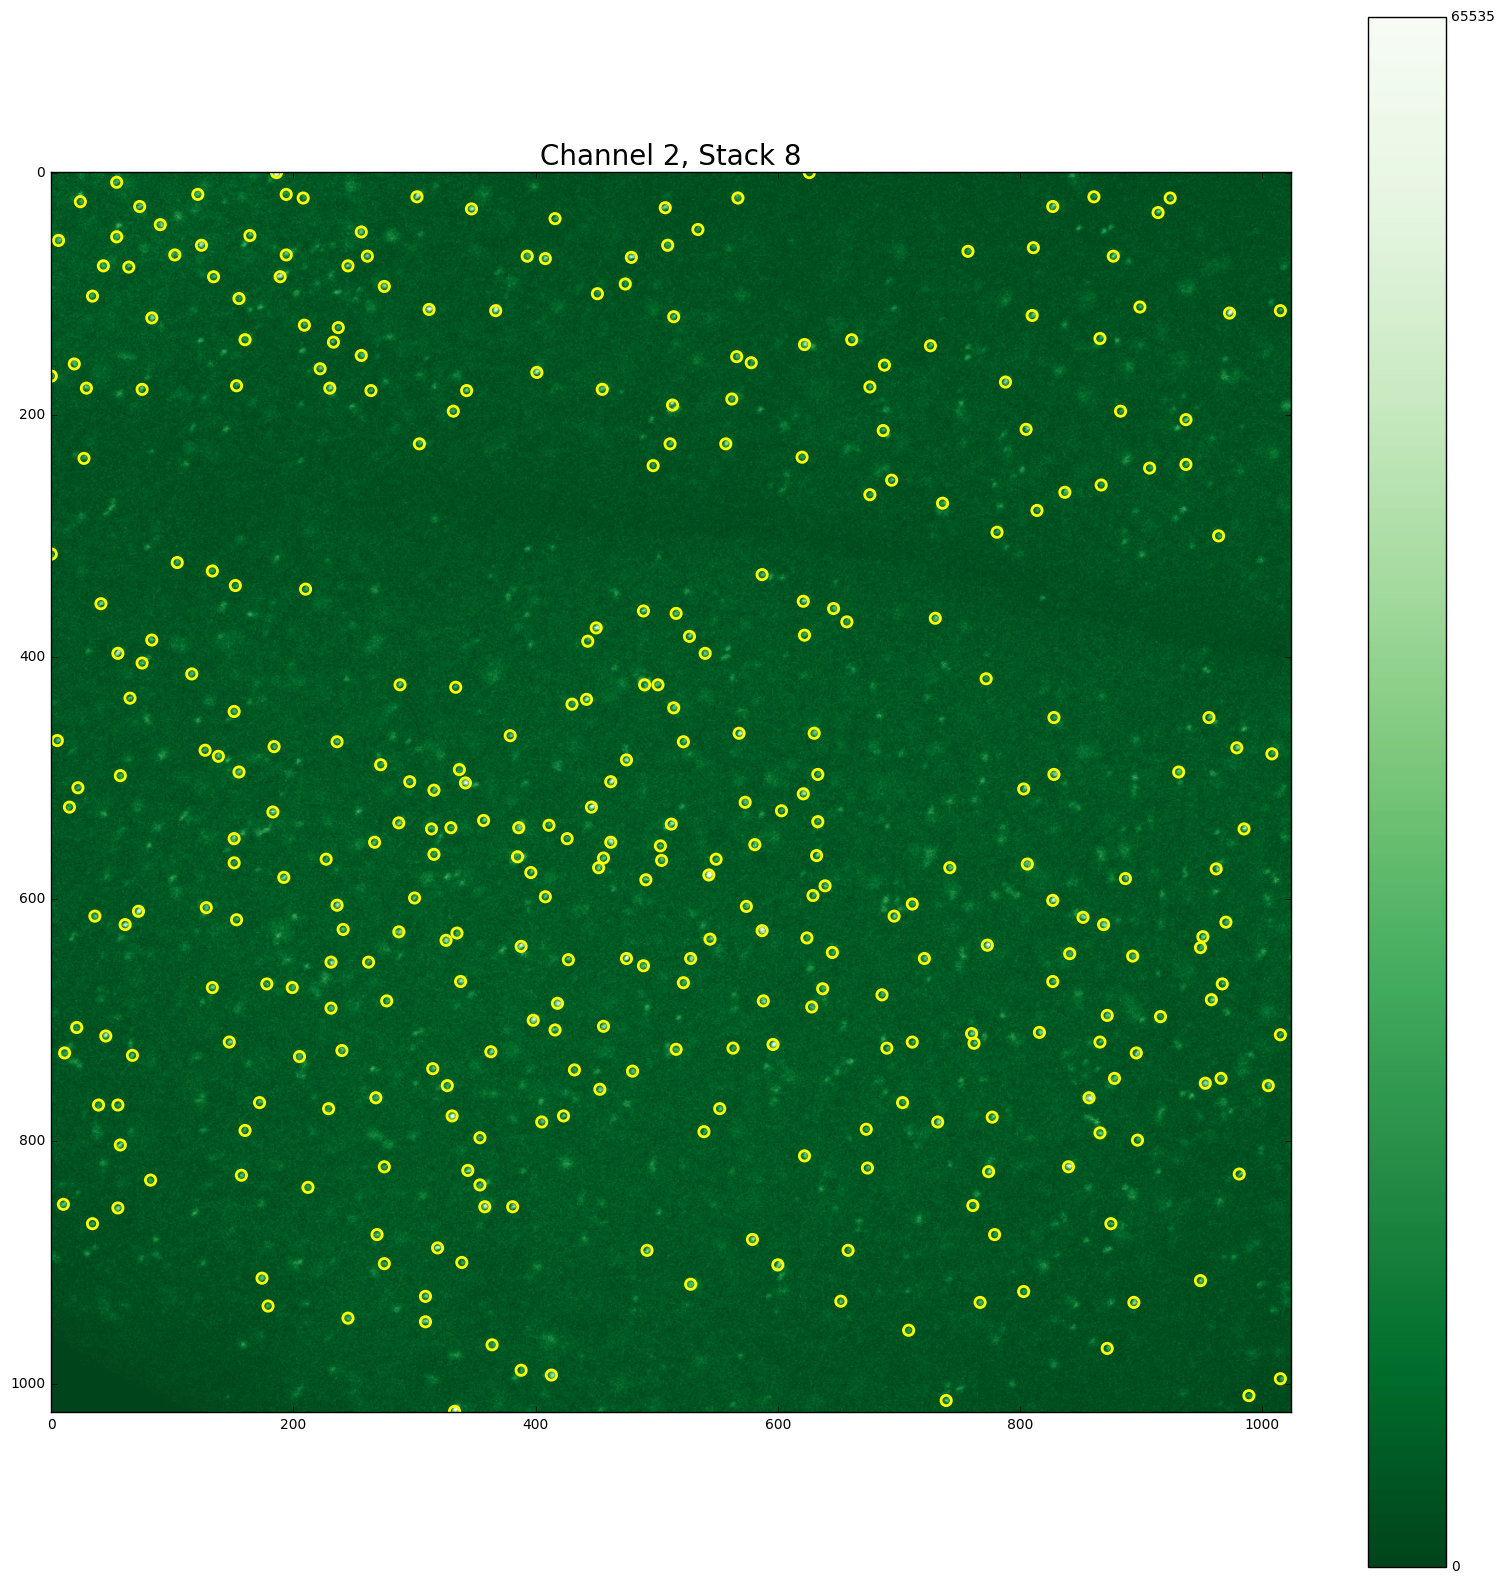

In [31]:
"""CHECK the blobs"""

stack=8   # Change stack number to inspect across Z-stack

channel=2 # to indicate colormap for plotting
PlotCheckBlobs(OneChannel_ss, blobsAll_ss,channel, stack,)
plt.savefig("Image1_blobs_ch{}_stack{}".format(channel,stack))

#channel=3 # to indicate colormap for plotting
#PlotCheckBlobs(OneChannel_klu, blobsAll_klu, channel, stack)



In [9]:
"""Cluster the blobs across planes"""
clusters_ss=GetClustersOneChannel(blobsList_ss)
clusters_klu=GetClustersOneChannel(blobsList_klu)

Estimated number of clusters: 2008
Estimated number of clusters: 1847


In [ ]:
'''CHECK the clusters'''
# Plot the clusters in 3D
PlotCheckClusters(clusters_ss)
plt.title("channel 2",fontsize=20)

PlotCheckClusters(clusters_klu)
plt.title("Channel 3",fontsize=20) 

In [10]:
'''Find the actual position of the signals'''
signals_ss=SignalPositionsOneChannel(clusters_ss,blobs_dict_ss)
signals_klu=SignalPositionsOneChannel(clusters_klu,blobs_dict_klu)

In [37]:
'''CHECK & plot the Actual Position of the two signals'''
y_s,x_s,z_s,i_s = ToActualScale(signals_ss).T
y_k,x_k,z_k,i_k = ToActualScale(signals_klu).T
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_s, y_s, z_s,color='green')
ax.scatter(x_k, y_k, z_k,color='red')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_zlim([-1,6])
plt.title("Actual Signal Positions", fontsize=20)
plt.show()

In [12]:
'''Find the pairs between the two channels'''
# empirically, distance between 2 dots won't exceed 1.4 microns
    '''Adjust Max pair distance here'''
limit=1.4
pairs=FindPairs(signals_ss,signals_klu,limit)
print "Found {} signal pairs".format(len(pairs))

Found 1055 signal pairs


In [13]:
'''CHECK & Plot all the pairs in 3D'''
pair_coord_pic=[]# This one has pixel coord
for pair in pairs:
    pair_coord_pic.append([signals_ss[pair[0]][0:3],signals_klu[pair[1]][0:3]])

pair_coord=[]# This one has actual coord
for i in range(len(pair_coord_pic)):
     pair_coord.append(ToActualScale(pair_coord_pic[i]))
PlotPairs3D(pair_coord)
#print pair_coord_pic

In [15]:
'''calculate the distance distribution of the pairs'''
distances=[pairs[index][2] for index in range(len(pairs))]
hist, bin_edges=np.histogram(distances,bins=25)
plt.bar(bin_edges[:-1],hist,width=0.03)
plt.xlim(0, 1.4)
plt.title('Distance Distribution of the Pairs')
plt.xlabel('Unit: um')
plt.ylabel('Number of Pairs')
plt.show()

In [75]:
'''plot pairs with a threshold PROJECTED to one image with a threshold'''    
# Background Channel
channel=0
stack=14
threshold=0
# lamin channel
PlotPairsProjected(image_arrays,channel,stack,pair_coord_pic,threshold)


In [76]:
'''Plot the pairs across the planes with certain channel stack one by one'''
# Background Channel
channel=0
threshold=0.8
for stack in range(0,1):
    PlotPairsImage(image_arrays,channel, stack, pair_coord_pic, threshold)

In [78]:
'''Spread out the stacks with actual signal and a background'''

# 1. plot actual signals
# 2. plot pairs with threshold

N_rows=6
N_cols=3
resolution=20
channel=1
threshold=0
# Show the WHOLE Z-STACK

#plt.figure(figsize = (resolution*N_cols,resolution*N_rows))
plt.figure(figsize = (50,50))

gs1 = gridspec.GridSpec(N_rows, N_cols)
#gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.20, hspace=0.20)

images=GetOneChannel(image_arrays,channel)

for stack in range(10):
    ax1 = plt.subplot(gs1[stack])
    plt.axis('on')
    image = images[stack]
    plt.imshow(image,cmap=colomap[channel])
    ax1.set_aspect('equal')
    
    selected=[]

    for pair in pair_coord_pic:
        #print pair
        distance=GetDistance(pair[0],pair[1])
        if distance<threshold:  # only take the pairs with distance above threshold
            continue
        if pair[0][2]>stack+0.5 or pair[0][2]<stack-0.5: # take the pairs near the stack
            continue

        selected.append(pair)

    y_s,x_s,z_s = np.array([selected[index][0] for index in range(len(selected))]).T
    y_k,x_k,z_k = np.array([selected[index][1] for index in range(len(selected))]).T

    ax1.scatter(x_s, y_s,color='green')
    ax1.scatter(x_k, y_k,color='red')
    ax1.set_xlabel('X Label')
    ax1.set_ylabel('Y Label')
    ax1.set_title("Channel {}, Stack {}".format(channel,stack),fontsize=20)

    #print log




In [79]:
#print pairs

print pair_coord_pic

print signal_ss

[[array([ 348.        ,  465.        ,    6.47599338]), array([ 347.54202202,  465.        ,    6.45797798])], [array([  75.        ,  933.        ,   21.46643531]), array([  75.53155096,  933.19375143,   21.49497333])], [array([  84.61064947,  297.38935053,   22.16124565]), array([  84.        ,  297.        ,   22.05944617])], [array([ 169.        ,  158.        ,    0.74656339]), array([ 169.        ,  157.56866328,    0.43133672])], [array([  2.60000000e+01,   1.02023621e+03,   8.54316599e-01]), array([  2.60000000e+01,   1.02000000e+03,   4.37978739e-01])], [array([ 452.        ,   78.53639939,    6.53639939]), array([ 452.        ,   79.        ,    6.13263106])], [array([ 641.        ,  422.        ,   11.98403465]), array([ 641.        ,  422.        ,   11.44773757])], [array([ 342.17691343,  548.        ,   19.6467242 ]), array([ 342.35589368,  548.        ,   19.11020329])], [array([ 688.75296546,  248.83104946,    4.62530115]), array([ 689.        ,  249.8274861 ,    4.4313

NameError: name 'signal_ss' is not defined

In [ ]:
# '''Check axes distribution of pairs on the image'''
# #print long
# y=np.array([long[index][0] for index in range(len(long))]).T
# x=np.array([long[index][1] for index in range(len(long))]).T
# z=np.array([long[index][2] for index in range(len(long))]).T
# #print y

# plt.subplot(131)
# hist, bin_edges=np.histogram(y,bins=10)
# plt.bar(bin_edges[:-1],hist,width=100)
# plt.xlim(0,1024)
# plt.title("Y Axis Position Distribution")
# plt.show()

# plt.subplot(132)
# hist, bin_edges=np.histogram(x,bins=10)
# plt.bar(bin_edges[:-1],hist,width=100)
# plt.xlim(0,1024)
# plt.title("X Axis Position Distribution")
# plt.show()

# plt.subplot(133)
# hist, bin_edges=np.histogram(z,bins=40)
# plt.bar(bin_edges[:-1],hist,width=0.05)
# plt.xlim(0,7)
# plt.title("Z Axis distance Distribution")
# plt.show()

In [12]:
'''extract & plot the pairs with distances above a threshold in 3D'''
threshold=0.8
PlotPairs3D(pair_coord,threshold)

In [16]:
'''Check pair orientation'''

y=np.array([pair_coord[index][0][0]-pair_coord[index][1][0] for index in range(len(pair_coord))]).T
x=np.array([pair_coord[index][0][1]-pair_coord[index][1][1] for index in range(len(pair_coord))]).T
z=np.array([pair_coord[index][0][2]-pair_coord[index][1][2] for index in range(len(pair_coord))]).T

plt.subplot(131)
hist, bin_edges=np.histogram(y,bins=40)
plt.bar(bin_edges[:-1],hist,width=0.05)
plt.xlim(-1.5, 1.5)
plt.axvline(0, color='k')
plt.title("Y axis distance distribution")
plt.show()

plt.subplot(132)
hist, bin_edges=np.histogram(x,bins=40)
plt.bar(bin_edges[:-1],hist,width=0.05)
plt.xlim(-1.5, 1.5)
plt.title("X axis distance distribution")
plt.axvline(0, color='k')
plt.show()

plt.subplot(133)
hist, bin_edges=np.histogram(z,bins=40)
plt.bar(bin_edges[:-1],hist,width=0.05)
plt.xlim(-1.5, 1.5)
plt.title("Z axis distance distribution")
plt.axvline(0, color='k')
plt.show()



In [17]:
'''Check where the Z plus or minus pairs are'''

z=np.array([pair_coord[index][0][2]-pair_coord[index][1][2] for index in range(len(pair_coord))]).T

selected_pairs=[]

for i in range(len(z)):
    if z[i]>0:
        selected_pairs.append(pair_coord[i])

print len(selected_pairs)
PlotPairs3D(selected_pairs)
plt.title('3D Plot of Pairs with >0 Z distance',fontsize=20)


selected_pairs=[]
for i in range(len(z)):
    if z[i]<0:
        selected_pairs.append(pair_coord[i])

print len(selected_pairs)
PlotPairs3D(selected_pairs)
plt.title('3D Plot of Pairs with <0 Z distance',fontsize=20)



873
182
